<a href="https://colab.research.google.com/github/binodmathews93/ML-Projects/blob/master/hacklive4_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

{}

In [3]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 5.7MB/s 
     |████████████████████████████████| 8.7MB 17.5MB/s 
     |████████████████████████████████| 808kB 43.5MB/s 
     |████████████████████████████████| 2.1MB 45.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from numpy import log

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

In [39]:
train = pd.read_csv('/content/Train_awoL0xl.csv')
test = pd.read_csv('/content/Test_QQKW4dv.csv')
ss = pd.read_csv('/content/SampleSubmission_ZxsCq0O.csv')

In [40]:
train.head(3)
test.head(3)

,ID,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
0,id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
1,id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
2,id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7


,ID,stock,Date,holiday,unpredictability_score
0,id_713,0,2019-11-01,0,7
1,id_714,0,2019-11-04,0,7
2,id_715,0,2019-11-05,0,7


In [41]:
ID_COL, TARGET_COL = 'id', 'Close'

In [42]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')


Train contains 73439 samples and 9 variables

Test contains 4223 samples and 5 variables


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73439 entries, 0 to 73438
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      73439 non-null  object 
 1   stock                   73439 non-null  int64  
 2   Date                    73439 non-null  object 
 3   Open                    73439 non-null  float64
 4   High                    73439 non-null  float64
 5   Low                     73439 non-null  float64
 6   Close                   73439 non-null  float64
 7   holiday                 73439 non-null  int64  
 8   unpredictability_score  73439 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 5.0+ MB


In [45]:
train['stock'].nunique()

103

In [46]:
test[test['stock'] == 93]['Date'].nunique()

41

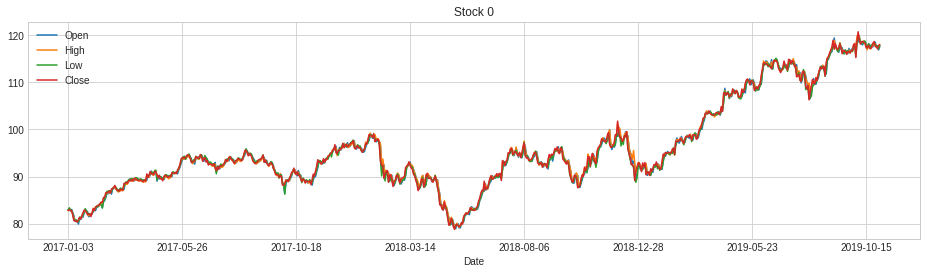

In [ ]:
STOCK_NO = 0
fltr = train['stock'] == STOCK_NO
_ = train[fltr].set_index('Date')[['Open', 'High', 'Low', 'Close']].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}')

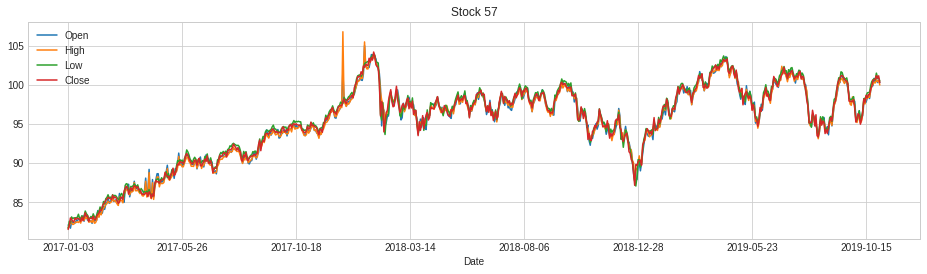

In [ ]:
STOCK_NO = 57
fltr = train['stock'] == STOCK_NO
_ = train[fltr].set_index('Date')[['Open', 'High', 'Low', 'Close']].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred) ** 0.5

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

###ARIMA

In [51]:
train['Date'] = pd.to_datetime(train["Date"])
test['Date'] = pd.to_datetime(test["Date"])

In [52]:
LAST_TRAINING_DAY = train['Date'].max()
DAYS_TO_VALIDATE = pd.Timedelta(days = 60)
VAL_FIRST_DAY = LAST_TRAINING_DAY - DAYS_TO_VALIDATE
LAST_TRAINING_DAY - VAL_FIRST_DAY

Timedelta('60 days 00:00:00')

In [53]:
val_fltr = train['Date'] >= VAL_FIRST_DAY
trn, val = train[~val_fltr].reset_index(drop = True), train[val_fltr].reset_index(drop = True)

In [73]:
trn[trn['stock'] == 0].set_index('Date').index[-1]

Timestamp('2019-08-30 00:00:00')

In [74]:
val[val['stock'] == 0].set_index('Date').index[0]

Timestamp('2019-09-03 00:00:00')

In [54]:
# Fit auto_arima function to stock 0 of train dataset 
stepwise_fit = auto_arima(trn[trn['stock'] == 0].set_index('Date')['Close'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3354.840, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1966.738, Time=2.01 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2739.062, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3376.382, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2147.821, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1912.622, Time=7.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.74 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3357.419, Time=3.54 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1914.462, Time=9.23 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1914.443, Time=8.50 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=2740.949, Time=5.02 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1914.714, Time=15.58 sec
 ARIMA(1,0,0)(2,1,0)[12]       

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  670
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -951.918
Date:                            Tue, 17 Nov 2020   AIC                           1911.836
Time:                                    05:43:06   BIC                           1929.793
Sample:                                         0   HQIC                          1918.797
                                            - 670                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9666      0.010    101.612      0.000       0.948       0.985
ar.S.L12      -0.6560      0.035    -18.794      0.000      -0.724      -0.588
ar.S.L24      -0.2953      0.033     -8.872      0.000      -0.361      -0.230
sigma2         1.0450      0.042     24.873      0.000       0.963       1.127
===================================================================================
Ljung-Box (Q):                      118.83   Jarque-Bera (JB):               102.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.81   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
model = SARIMAX(trn[trn['stock'] == 0].set_index('Date')['Close'],  
                order = (1 , 0 , 0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  670
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -951.918
Date:                            Tue, 17 Nov 2020   AIC                           1911.836
Time:                                    05:51:21   BIC                           1929.793
Sample:                                         0   HQIC                          1918.797
                                            - 670                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9666      0.010    101.612      0.000       0.948       0.985
ar.S.L12      -0.6560      0.035    -18.794      0.000      -0.724      -0.588
ar.S.L24      -0.2953      0.033     -8.872      0.000      -0.361      -0.230
sigma2         1.0450      0.042     24.873      0.000       0.963       1.127
===================================================================================
Ljung-Box (Q):                      118.83   Jarque-Bera (JB):               102.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.81   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
diff_date = val['Date'].min() - trn['Date'].max()
diff_date.days

4

In [1]:
start = trn.shape[0] + (val['Date'].min() - trn['Date'].max()).days
end = start + 60
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
val[val['stock'] == 0].set_index('Date').plot(legend = True)

NameError: ignored

###Logistic Regression

In [ ]:
clf = LogisticRegression()

param_tuning = {
        #'boosting_type': ['gbdt', 'rf' ,'dart', 'goss'],
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators' : [500, 1000, 1500]
    }

cvts = TimeSeriesSplit(n_splits=5)

gsearch = GridSearchCV(estimator = clf,
                           param_grid = param_tuning,
                           cv = cvts,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(trn[features], trn['Close'])
print(gsearch.best_params_)

In [ ]:
# now we fit model with entire training dataset before submitting
clf.fit(train[features], train['Close'])

pt = clf.predict(test[features])
download_preds(pt, 'lightgbm_base.csv')

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=9025, n_jobs=-1, num_leaves=15, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('lightgbm_base.csv')

,ID,Close
0,id_713,114.797009
1,id_714,116.093336
2,id_715,116.107774
3,id_716,116.140402
4,id_717,116.140402
...,...,...
4218,id_77657,122.752571
4219,id_77658,123.055499
4220,id_77659,122.836243
4221,id_77660,127.341171


In [ ]:
preds_test_df = test.copy()
preds_test_df['Close'] = pt

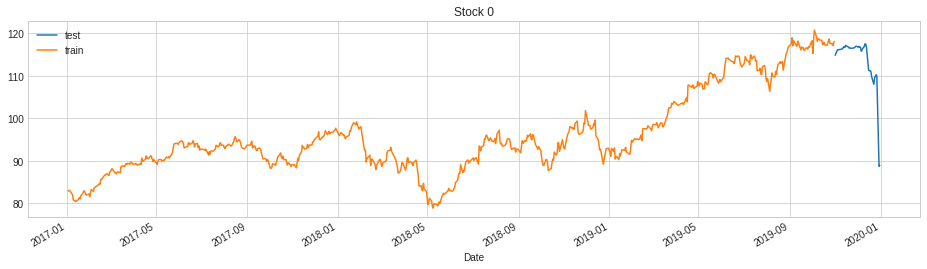

In [ ]:
STOCK_NO = 0
train_fltr = train['stock'] == STOCK_NO
train_tmp = train[train_fltr].set_index('Date')[['Close']]
train_tmp['type'] = 'train'
test_fltr = preds_test_df['stock'] == STOCK_NO
test_tmp = preds_test_df[test_fltr].set_index('Date')[['Close']]
test_tmp['type'] = 'test'
_ = train_tmp.append(test_tmp).groupby('type')['Close'].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}', sharex=False)
_ = plt.legend()

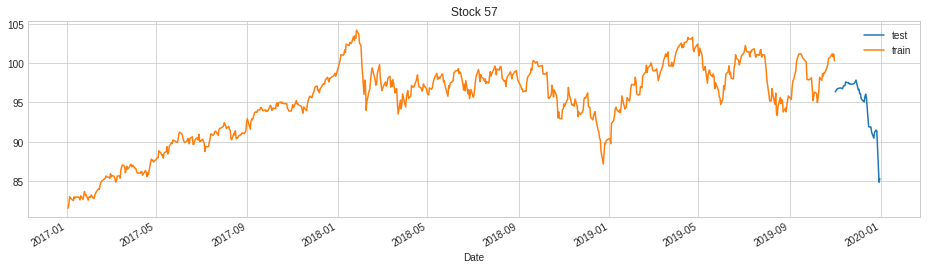

In [ ]:
STOCK_NO = 57
train_fltr = train['stock'] == STOCK_NO
train_tmp = train[train_fltr].set_index('Date')[['Close']]
train_tmp['type'] = 'train'
test_fltr = preds_test_df['stock'] == STOCK_NO
test_tmp = preds_test_df[test_fltr].set_index('Date')[['Close']]
test_tmp['type'] = 'test'
_ = train_tmp.append(test_tmp).groupby('type')['Close'].plot(figsize=(16, 4), title = f'Stock {STOCK_NO}', sharex=False)
_ = plt.legend()